In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9504vna_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9504vna_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=e6d8598db1c88432d4401cc3893784be999259e4034f5138ab17d3de490df05a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_btik44z/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-03-20 12:09:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.160.213.103, 18.160.213.57,

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
image = cv2.imread('dogs/shiba.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

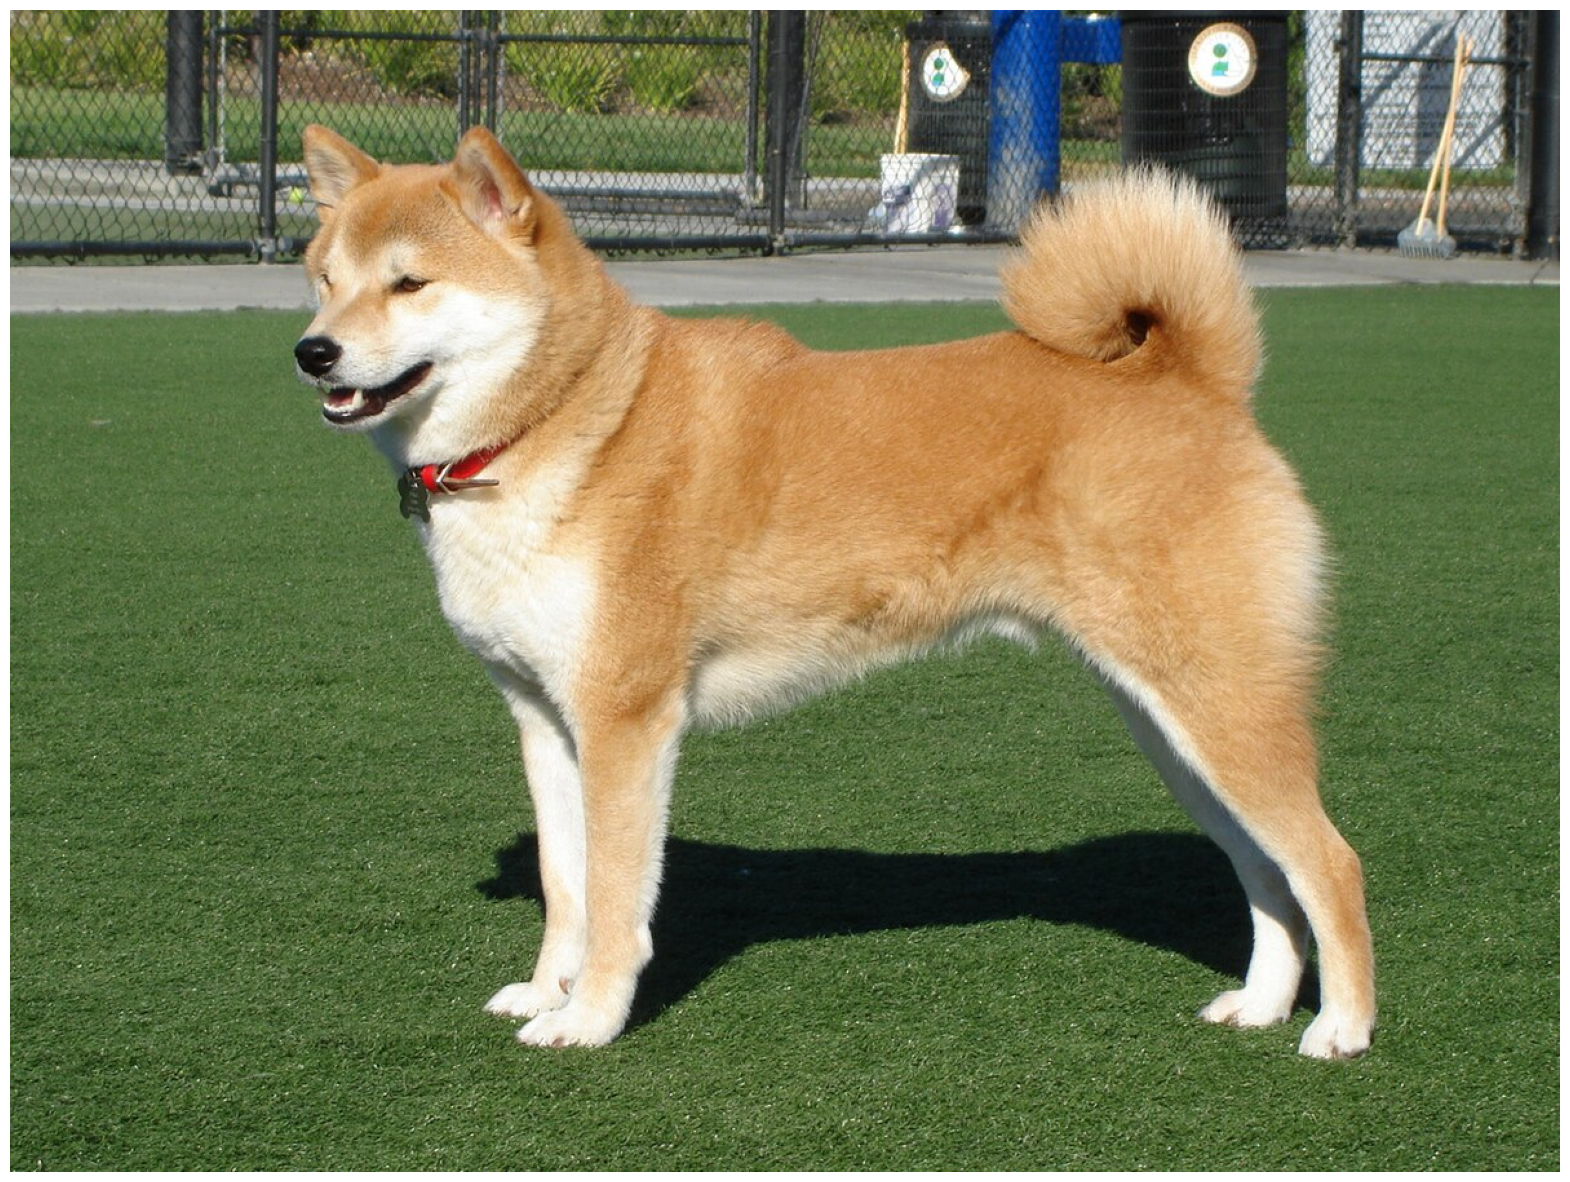

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image)

In [9]:
print(len(masks))
print(masks[0].keys())

42
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


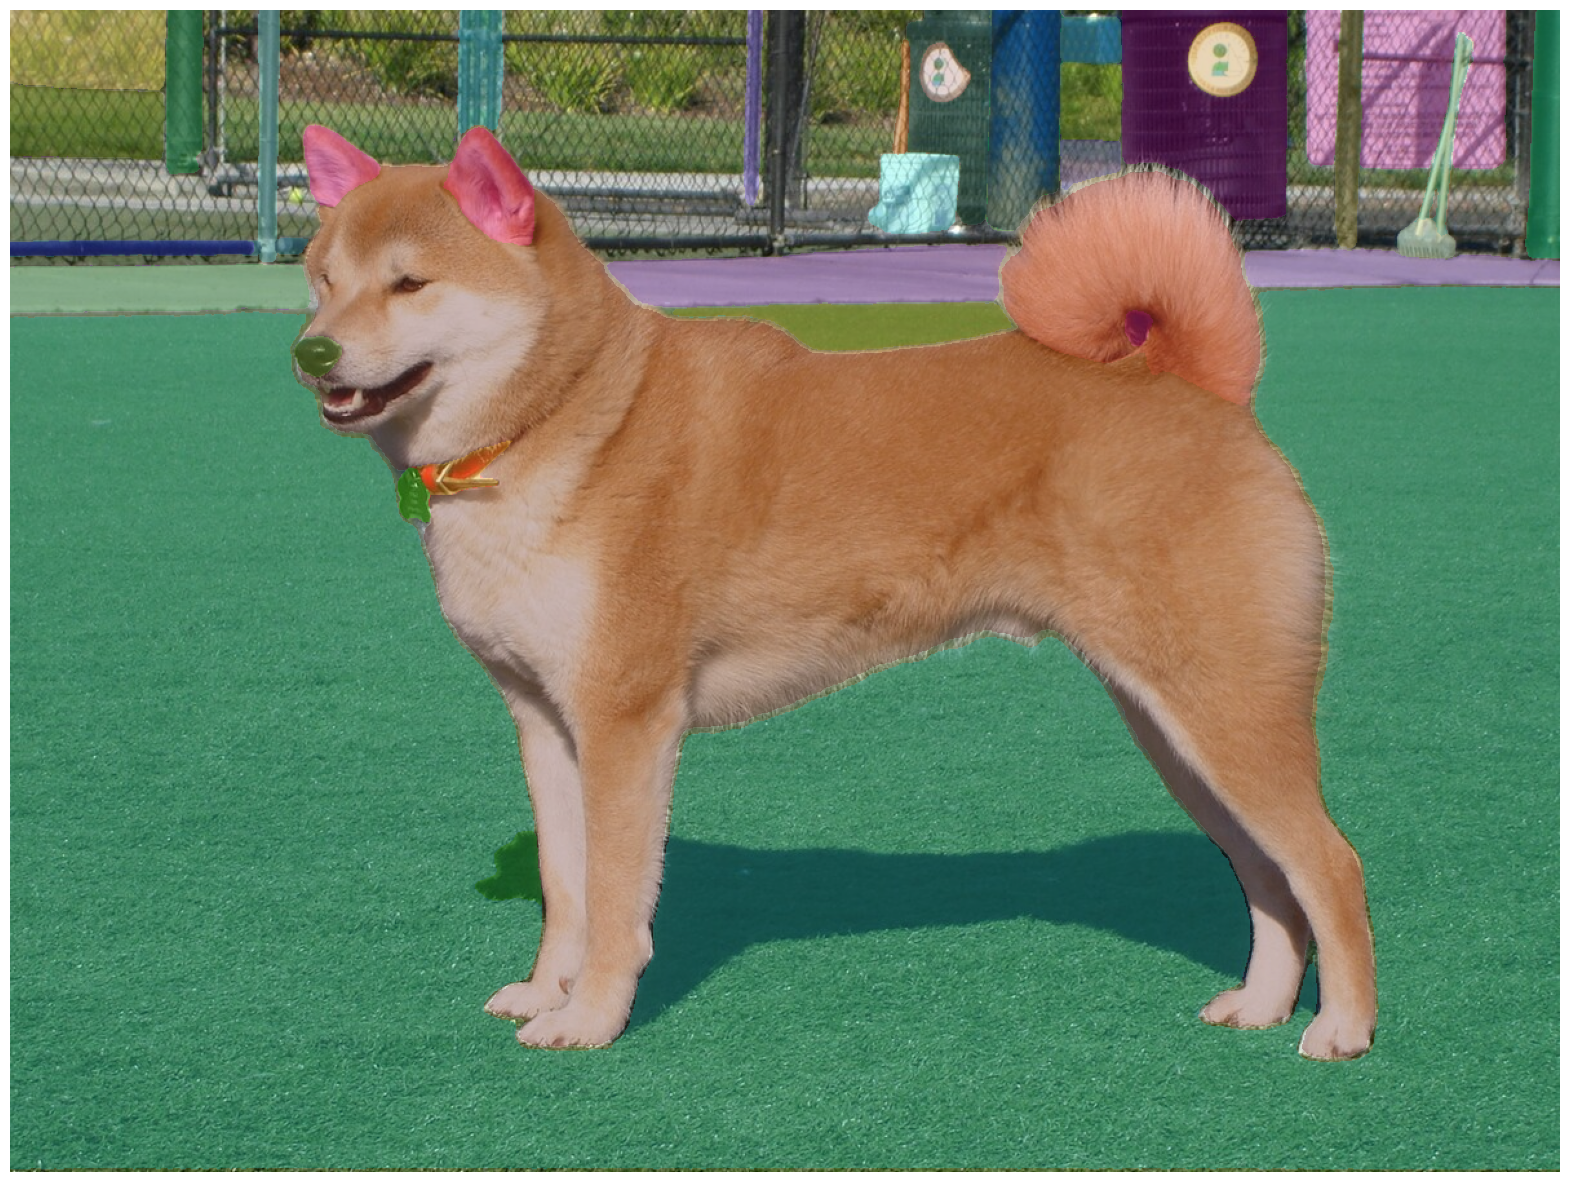

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

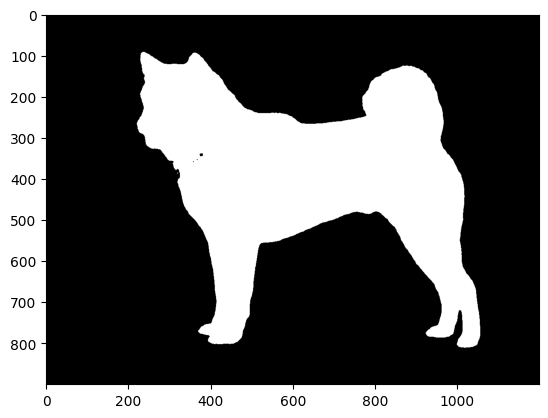

In [11]:
plt.imshow(masks[0]['segmentation'], cmap='gray')
plt.show()

In [16]:
import os
import glob
import re

In [18]:
path = "./dogs"

image_dict = {}
for filename in glob.glob(os.path.join('./dogs', '*.jpeg')):
    with open(filename, 'r') as f:
      match = re.search(r'\/(\w+)\.', filename)
      image = cv2.imread(filename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      masks = mask_generator.generate(image)
      image_dict[match.group(1)] = masks

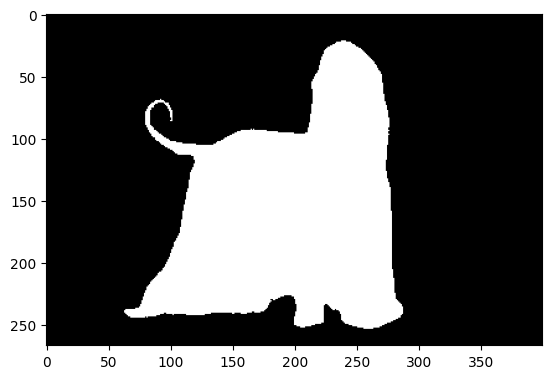

In [48]:
plt.imshow(image_dict['afghan'][0]['segmentation'], cmap='gray')
plt.show()

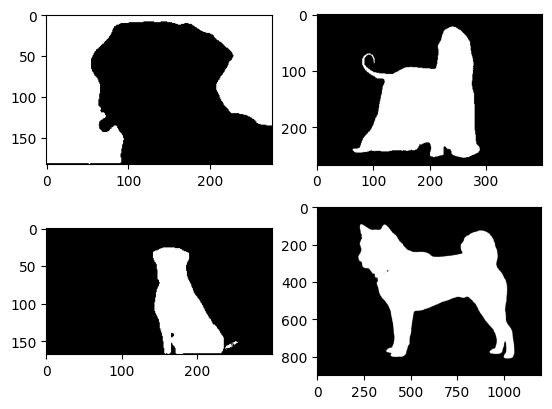

In [45]:
import matplotlib.image as mpimg

images = [image_dict['lab'][0]['segmentation'],
          image_dict['afghan'][0]['segmentation'],
          image_dict['rot'][2]['segmentation'],
          image_dict['shiba'][0]['segmentation']]

fig = plt.figure()

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)  # we start from i+1 because subplot indices start from 1
    ax.imshow(images[i], cmap='gray')

plt.show()

In [46]:
import pickle

with open('masks.pkl', 'wb') as f:
    pickle.dump(image_dict, f)